# Тестовое задание
# 1. Часть 1. SQL
1. Есть таблица [FactSales]: Интересующие поля - [SalesAmountFull], [SalesQuantityFull], [PartnerKey], [ProductKey], [DateKey]. Соответственно по порядку продажи в деньгах, продажи в шт, кто купил, что купил, дата.
* Задание: Посчитать ПО МЕСЯЦАМ скользящую годовую сумму продаж (и деньги и шт) в разрезе Месяц(например 202005)-[PartnerKey]-[ProductKey], т.е сколько какого товара купил контрагент суммарно за текущий и 11 предыдущих месяцев.
* PS. Данные у нас условно с 2010 года например.
* Результат - *.txt файл с SQL-кодом

In [ ]:
# задача довольно сложная, поэтому я создал у себя на домашнем ПК схожую таблицу для тестирования работы SQL-запроса
# запросы по созданию, наполнению и тестированию выполнял из pgAdmin:
'''
CREATE TABLE FactSales (
  SaleID SERIAL PRIMARY KEY, 
  SalesAmountFull REAL, 
  SalesQuantityFull INTEGER,
  PartnerKey INTEGER, 
  ProductKey INTEGER, 
  DateKey DATE
);
'''

In [ ]:
# и наполнил ее данными, например (один из кусков):
'''
INSERT INTO FactSales (
  SalesAmountFull, SalesQuantityFull, 
  PartnerKey, ProductKey, DateKey
) 
VALUES 
  (100.0, 10, 1, 69, '2010-01-01'), 
  (220.0, 11, 1, 666, '2010-01-15'), 
  (100.0, 10, 1, 69, '2010-02-01'), 
  (220.0, 11, 1, 666, '2010-02-15'), 
  (100.0, 10, 1, 69, '2010-03-01'), 
  (220.0, 11, 1, 666, '2010-03-15'), 
  (100.0, 10, 1, 69, '2010-04-01'), 
  (220.0, 11, 1, 666, '2010-04-15'), 
  (100.0, 10, 1, 69, '2010-05-01'), 
  (220.0, 11, 1, 666, '2010-05-15'), 
  (100.0, 10, 1, 69, '2010-06-01'), 
  (220.0, 11, 1, 666, '2010-06-15'), 
  (100.0, 10, 1, 69, '2010-07-01'), 
  (220.0, 11, 1, 666, '2010-07-15'), 
  (100.0, 10, 1, 69, '2010-08-01'), 
  (220.0, 11, 1, 666, '2010-08-15'), 
  (100.0, 10, 1, 69, '2010-09-01'), 
  (220.0, 11, 1, 666, '2010-09-15'), 
  (100.0, 10, 1, 69, '2010-10-01'), 
  (220.0, 11, 1, 666, '2010-10-15'), 
  (100.0, 10, 1, 69, '2010-11-01'), 
  (220.0, 11, 1, 666, '2010-11-15'), 
  (100.0, 10, 1, 69, '2010-12-01'), 
  (220.0, 11, 1, 666, '2010-12-15'), 
  (100.0, 10, 1, 69, '2011-01-01'), 
  (220.0, 11, 1, 666, '2011-01-15'), 
  (100.0, 10, 1, 69, '2011-02-01'), 
  (220.0, 11, 1, 666, '2011-02-15'), 
  (100.0, 10, 1, 69, '2011-03-01'), 
  (220.0, 11, 1, 666, '2011-03-15');
'''  

В таблице есть записи с 2010 по 2012гг, введены примеры для 2х партнеров: "1" и "2", и 2 продуктов "69" и "666"

In [1]:
# для подтверждения правильности работы дополнительно сделал вывод из БД в блокнот
import psycopg2
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT

In [7]:
# подключение к БД
conn = psycopg2.connect(database="sqlalchemy_tuts", user="postgres", password="2wsx3edc")
conn.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)

In [33]:
# итоговый SQL-запрос выполняющий заданную задачу (в нем используются временные таблицы и подзапрос):
action = '''
WITH tmp_1 AS (
  SELECT 
    *, 
    date_part('year', DateKey) AS date_year, 
    date_part('month', DateKey) AS date_month, 
    RANK() OVER (
      ORDER BY 
        DATE_TRUNC('month', DateKey)
    ) AS month_rank, 
    RANK() OVER (
      ORDER BY 
        PartnerKey, 
        ProductKey
    ) AS tmp_rank, 
    SUM(SalesAmountFull) OVER ppd AS parther_sum_amt, 
    SUM(SalesQuantityFull) OVER ppd AS parther_sum_qt 
  FROM 
    FactSales WINDOW ppd AS (
      PARTITION BY PartnerKey, 
      ProductKey, 
      DATE_TRUNC('month', DateKey)
    ) 
  ORDER BY 
    DateKey
), 
tmp_2 AS (
  SELECT 
    tmp_1.date_year, 
    tmp_1.date_month, 
    tmp_1.PartnerKey, 
    tmp_1.ProductKey, 
    tmp_1.month_rank, 
    tmp_1.tmp_rank, 
    MAX(tmp_1.parther_sum_amt) as month_sum_amt, 
    MAX(tmp_1.parther_sum_qt) as month_sum_qt 
  FROM 
    tmp_1 
  GROUP BY 
    (
      PartnerKey, ProductKey, tmp_1.month_rank, 
      tmp_1.date_year, tmp_1.date_month, 
      tmp_rank
    ) 
  ORDER BY 
    month_rank
) 
SELECT 
  date_year, 
  date_month, 
  PartnerKey, 
  ProductKey, 
  month_sum_amt,
  month_sum_qt,
  SUM(month_sum_amt) OVER roll_sum_wnd AS roll_sum_amt, 
  SUM(month_sum_qt) OVER roll_sum_wnd AS roll_sum_qt 
FROM 
  tmp_2 WINDOW roll_sum_wnd AS (
    PARTITION BY tmp_2.tmp_rank 
    ORDER BY 
      tmp_2.month_rank ROWS BETWEEN 11 PRECEDING 
      AND 0 FOLLOWING
  ) 
ORDER BY 
  tmp_2.date_year, 
  tmp_2.date_month;
'''

In [34]:
# выполним запрос
cur = conn.cursor()
cur.execute(action)
records = cur.fetchall()
conn.commit()

In [40]:
# преобразуем результат в датафрейм для более наглядного отображения
records = np.array(records)
df = pd.DataFrame(records, columns=['Year', 'Month', 'PartnerKey', 'ProductKey', 'mnth_sum_amt', 'mnth_sum_qt', 'roll_sum_amt', 'roll_sum_qt'])
df['Year'] = df['Year'].astype(int)
df['Month'] = df['Year'].astype(int)
df['PartnerKey'] = df['PartnerKey'].astype(int)
df['ProductKey'] = df['ProductKey'].astype(int)

In [41]:
# mnth_sum_amt - сумма продаж за 1 месяц по каждому сочетанию PartnerKey+ProductKey из SalesAmountFull 
# mnth_sum_qt - количество продаж за 1 месяц по каждому сочетанию PartnerKey+ProductKey из SalesQuantityFull
# oll_sum_amt - оконная функция скользящей суммы с заданным условием по суммам продаж
# roll_sum_qt - оконная функция скользящей суммы с заданным условием по количеству продаж

df.head(24)

,Year,Month,PartnerKey,ProductKey,mnth_sum_amt,mnth_sum_qt,roll_sum_amt,roll_sum_qt
0,2010,2010,1,69,200.0,20,200.0,20
1,2010,2010,1,666,440.0,22,440.0,22
2,2010,2010,2,69,2000.0,200,2000.0,200
3,2010,2010,2,666,4400.0,220,4400.0,220
4,2010,2010,2,69,2000.0,200,4000.0,400
5,2010,2010,2,666,4400.0,220,8800.0,440
6,2010,2010,1,69,200.0,20,400.0,40
7,2010,2010,1,666,440.0,22,880.0,44
8,2010,2010,2,666,4400.0,220,13200.0,660
9,2010,2010,1,69,200.0,20,600.0,60


Как это выглядит в pgAdmin:

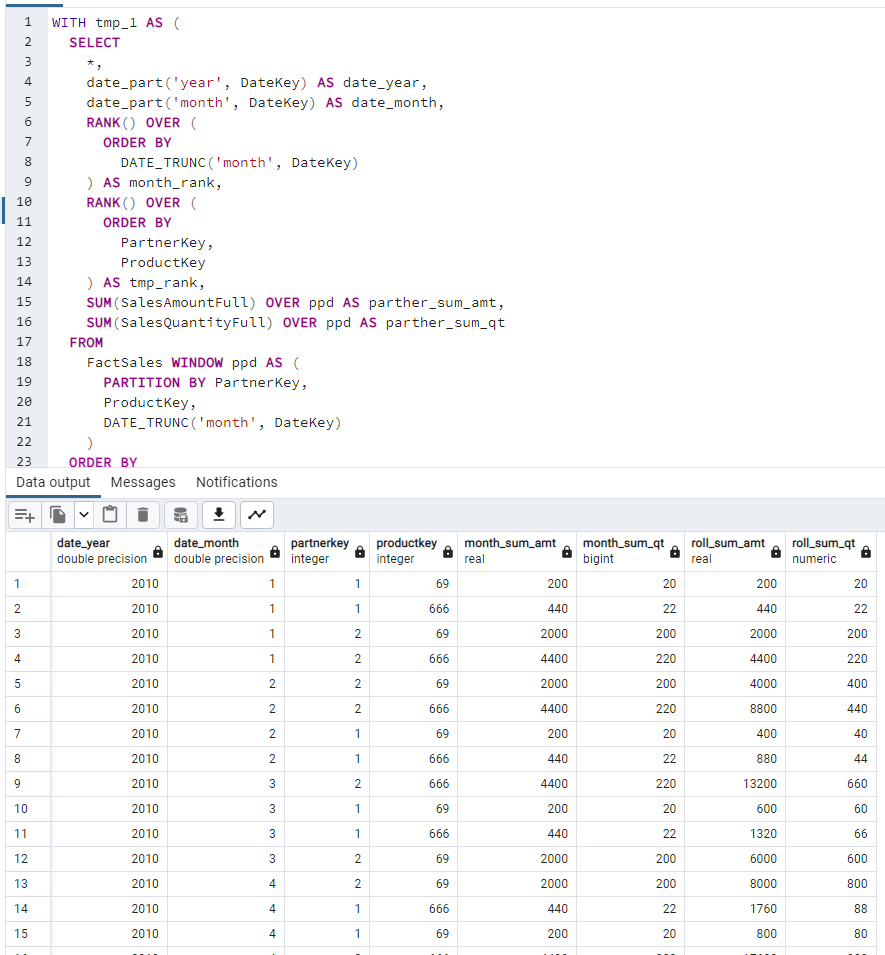

# 2. Часть 2. Python & ML
2. Создать лаги продаж на период от 1 дня до 2 недель для каждого SKU из файла test_for_lags.pkl
3. Файл task_2_ содержит данные о сессиях пользователей. Одна строчка в файле содержит факторы, посчитанные по одной дневной сессии пользователя (одна строка = один пользователь). В строке факторы разделены между собой знаками табуляции, физический смысл факторов не раскрывается. Известно, что в файле присутствуют как сессии живых людей, так и роботов. Также известно, что роботные сессии отличаются от сессий живых пользователей тем, что имеют определенные закономерности в поведении (для нашего случая в значениях факторов). 
* Необходимо разделить сессии на две части - роботные и человеческие. Известно, что под каждую закономерность может попадать не более 20% сессий. Количество закономерностей (=правил) - не меньше трех. Количество факторов в каждом правиле - не менее четырех.  Один из способов решения задания (не обязательно использовать
его!): http://en.wikipedia.org/wiki/Association_rule_learning 
* Выполненное задание должно содержать *.ipynb файл с кодом , описание выбранной методики, ход мыслей, словесное описание полученных результатов, получившиеся правила (если методом был выбраны ассоциативные правила), а также разделенные на 2 части сессии - роботные и человеческие.

## 2.1. Импорты

In [1]:
#from apyori import apriori
import pandas as pd
import numpy as np
import sys
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(20, 6)})

import datetime

## 2.2. Загрузка и первоначальное знакомство с данными

### 2.2.1. Файл 'test_for_lags.pkl'

In [2]:
test_for_lags = pd.read_pickle(r'F:\Desktop\DS\IEC\Тестовое\test_for_lags.pkl')

In [3]:
test_for_lags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308304 entries, 0 to 308303
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   DateKey     308304 non-null  datetime64[ns]
 1   ProductKey  308304 non-null  int32         
 2   sales_qnty  308304 non-null  int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 4.7 MB


In [4]:
test_for_lags.head()

,DateKey,ProductKey,sales_qnty
0,2020-02-17,694085,192
1,2020-02-21,718133,6859
2,2020-02-25,744235,2040
3,2020-05-06,777569,53
4,2020-05-16,766750,27993


In [5]:
test_for_lags.describe()

,ProductKey,sales_qnty
count,308304.000000,3.083040e+05
mean,706644.318624,1.314437e+03
std,52636.940939,3.717582e+04
min,0.000000,-2.949350e+05
25%,663821.000000,1.200000e+01
50%,697650.000000,6.000000e+01
75%,743244.000000,3.000000e+02
max,848822.000000,1.797017e+07


In [6]:
# замечено, что количество заказов где-то принимает отрицательные значения - надо посмотреть где это произошло?
test_for_lags.query('sales_qnty<0')

,DateKey,ProductKey,sales_qnty
172,2020-05-27,828045,-15
218,2020-05-14,770612,-84
248,2020-01-13,668783,-7
363,2020-06-01,826346,-3
390,2020-03-11,748634,-19
...,...,...,...
307583,2020-05-27,810730,-90
307675,2020-05-27,828106,-30
307886,2020-01-13,664242,-10
307980,2020-01-16,703013,-3


In [7]:
# таких данных довольно много - 2883 шт, не понятно что это - ошибка ввода (и надо тогда их взять по модулю), или значение этого столбца НЕ "количество заказов"
# но нам надо получить лаги, а даже такие значения - это какая-то активность, поэтому возьмем эти значение по модулю
test_for_lags['sales_qnty'] = test_for_lags['sales_qnty'].apply(abs)

### Предварительные выводы по файлу 'test_for_lags.pkl':
1. Пропусков в данных нет, формат данных корректный.
2. Поле 'sales_qnty' содержит значения меньше нуля!

In [8]:
# для того, чтобы оперировать с данными, как с временным рядом, назначим время индексом, предварительно отсортировав его
test_for_lags = test_for_lags.sort_values (by = 'DateKey', ascending = True)
test_for_lags = test_for_lags.set_index('DateKey')

In [9]:
print('Данные отсортированы по времени:', test_for_lags.index.is_monotonic_increasing)

Данные отсортированы по времени: True


In [10]:
print('Имеем данные за период:', test_for_lags.index.min(), '-', test_for_lags.index.max())

Имеем данные за период: 2020-01-01 00:00:00 - 2020-06-01 00:00:00


In [11]:
# т.к. надо посчитать лаги от отдного дня, то надо сделать ресемплинг количества заказов по дням
test_for_lags_1D = test_for_lags.drop('ProductKey', axis=1).resample('1D', label='right').sum()

In [12]:
test_for_lags_1D.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 153 entries, 2020-01-02 to 2020-06-02
Freq: D
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   sales_qnty  153 non-null    int64
dtypes: int64(1)
memory usage: 2.4 KB


In [13]:
test_for_lags_1D.head()

,sales_qnty
DateKey,
2020-01-02,1120
2020-01-03,0
2020-01-04,0
2020-01-05,0
2020-01-06,0


<AxesSubplot: title={'center': 'График заказов по дням'}, xlabel='Время заказа', ylabel='Количество заказов'>

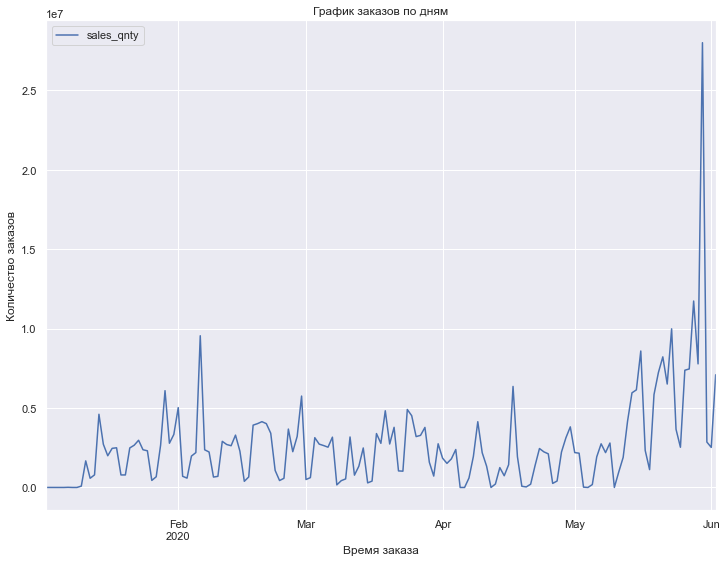

In [14]:
test_for_lags_1D.plot(figsize=[12,9], title='График заказов по дням', xlabel='Время заказа', ylabel='Количество заказов')

In [15]:
# заказы идут не только в рабочие дни, поэтому используем именно "1D", а не "1B"

In [16]:
test_for_lags_1D.query('sales_qnty==0')

,sales_qnty
DateKey,
2020-01-03,0
2020-01-04,0
2020-01-05,0
2020-01-06,0
2020-01-08,0
2020-01-09,0
2020-04-12,0
2020-05-04,0
2020-05-10,0


In [17]:
# объединим их в слитные интервалы
day_lags = list(test_for_lags_1D.query('sales_qnty==0').index)

In [18]:
day_lags

[Timestamp('2020-01-03 00:00:00'),
 Timestamp('2020-01-04 00:00:00'),
 Timestamp('2020-01-05 00:00:00'),
 Timestamp('2020-01-06 00:00:00'),
 Timestamp('2020-01-08 00:00:00'),
 Timestamp('2020-01-09 00:00:00'),
 Timestamp('2020-04-12 00:00:00'),
 Timestamp('2020-05-04 00:00:00'),
 Timestamp('2020-05-10 00:00:00')]

In [19]:
day_lags[0] - day_lags[1]

Timedelta('-1 days +00:00:00')

In [20]:
delta_t = datetime.timedelta(days=1,
                             seconds=0,
                             microseconds=0,
                             milliseconds=0,
                             minutes=0,
                             hours=0,
                             weeks=0)

In [25]:
lag_list = []
lag_str = ''

for i in range(len(day_lags)):
    if i!=len(day_lags)-1:
        if day_lags[i+1]-day_lags[i]<=delta_t:
            if lag_str=='':
                lag_str = day_lags[i].strftime("%Y-%m-%d")
        else:
            if lag_str!='':
                lag_str = lag_str + f' - {day_lags[i].strftime("%Y-%m-%d")}'
                lag_list.append(lag_str)
                lag_str = ''

print('Обнаружены следующие лаги по продажам:')
for lag in lag_list:
    print(lag)                

Обнаружены следующие лаги по продажам:
2020-01-03 - 2020-01-06
2020-01-08 - 2020-01-09


In [26]:
# теперь посмотрим лаги по 2-недельным интервалам
test_for_lags_2W = test_for_lags.drop('ProductKey', axis=1).resample('2W', label='right').sum()

<AxesSubplot: title={'center': 'График заказов по 2-недельным интервалам'}, xlabel='Время заказа', ylabel='Количество заказов'>

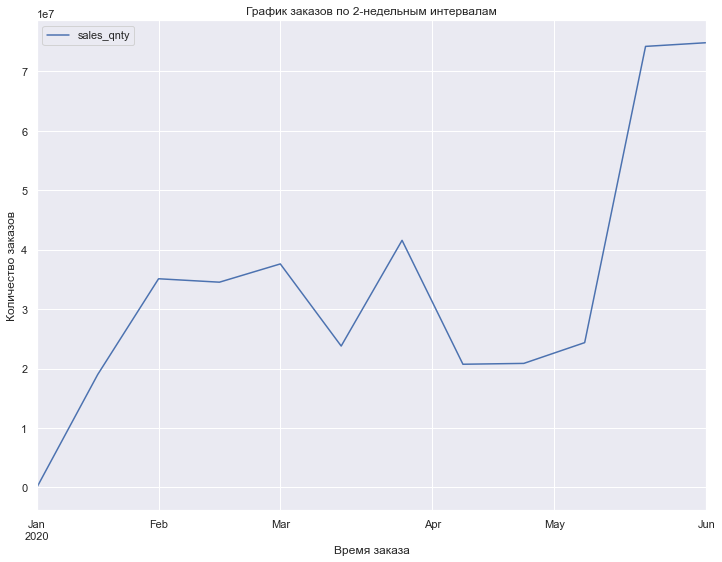

In [27]:
test_for_lags_2W.plot(figsize=[12,9], title='График заказов по 2-недельным интервалам', xlabel='Время заказа', ylabel='Количество заказов')

### Итоговые выводы по файлу 'test_for_lags.pkl':
1. обнаружены следующие лаги продаж по дням: 
* с 2020-01-03 по 2020-01-06
* с 2020-01-08 по 2020-01-09
2. лагов по 2-недельным интервалам не замечено.

### 2.2.2. Файл 'task2_1_'

In [2]:
names = ['session_id'] + list(np.arange(187))

In [4]:
data = pd.read_csv(r'F:\Desktop\DS\IEC\Тестовое\task2_1_', sep='\t', names=names)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49958 entries, 0 to 49957
Columns: 188 entries, session_id to 186
dtypes: int64(43), object(145)
memory usage: 71.7+ MB


In [6]:
data = data[::10]

In [7]:
data.sample(10)

,session_id,0,1,2,3,4,5,6,7,8,...,177,178,179,180,181,182,183,184,185,186
9330,2ff079d3094992880e50cdb10fe21632,-,0,1,1399286492,0,-,16,0,0,...,0,-,-,-,-,-,-,-,-,-
15500,5049a78654ab048ab5f2072b6d4f352d,-,0,0,1399315430,0,-,18,0,0,...,0,-,-,-,-,-,-,-,-,-
3560,128fb1d6c5934e00e293e3c3f51c7f11,-,0,-,1297258190,1180,-,-,0,0,...,-,-,-,-,-,-,-,-,-,-
15030,4dd124f864b600734328183dbf7fdfc9,1,0,0,1372962137,304,-,14,0,0,...,0,-,-,-,-,-,-,-,-,-
12640,4133f5ea4b9ed8596c3b9c2024c35889,-,0,-,1394492424,55,-,-,0,0,...,-,-,-,-,-,-,-,-,-,-
31280,a04a7622fe222d96957ba848dae7b2e6,1,0,0,1359547263,459,-,0,0,0,...,0,-,-,-,-,-,-,-,-,-
23440,78214722166535999c607963c0932d80,-,0,0,1399305604,0,-,17,0,0,...,0,-,-,-,-,-,-,-,-,-
9100,2ebced95307db9dbe581e9c068a02161,-,0,-,1394569453,54,-,-,0,0,...,-,-,-,-,-,-,-,-,-,-
26440,877d249b7df6949c75a8aff9bf1137ff,-,0,-,1396151826,35,-,-,0,0,...,-,-,-,-,-,-,-,-,-,-
44200,e22cd84afad7a5216db27829509b0347,-,0,-,1393597688,65,-,-,0,0,...,-,-,-,-,-,-,-,-,-,-


In [8]:
data.shape

(4996, 188)

In [9]:
data.reset_index(drop=True, inplace=True)

In [10]:
data.describe()

,1,3,4,7,8,9,12,13,14,15,...,100,101,138,139,140,157,158,169,173,174
count,4996.0,4.996000e+03,4996.000000,4996.000000,4996.0,4996.0,4996.000000,4.996000e+03,4996.000000,4.996000e+03,...,4996.0,4996.0,4996.0,4996.000000,4996.000000,4996.000000,4996.0,4996.0,4996.0,4996.000000
mean,0.0,1.388477e+09,124.624900,0.001001,0.0,0.0,17509.374500,1.399274e+09,10.866293,1.399292e+09,...,0.0,0.0,0.0,13.942554,0.002402,1.262810,0.0,0.0,0.0,0.019015
std,0.0,1.800220e+07,208.233137,0.031623,0.0,0.0,23859.249321,2.430607e+04,6.719828,2.245791e+04,...,0.0,0.0,0.0,50.228360,0.052887,2.137137,0.0,0.0,0.0,0.136592
min,0.0,1.223313e+09,0.000000,0.000000,0.0,0.0,0.000000,1.399234e+09,0.000000,1.399234e+09,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
25%,0.0,1.382365e+09,0.000000,0.000000,0.0,0.0,15.000000,1.399257e+09,6.000000,1.399279e+09,...,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000
50%,0.0,1.397034e+09,25.000000,0.000000,0.0,0.0,1732.000000,1.399273e+09,10.000000,1.399297e+09,...,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000
75%,0.0,1.399264e+09,195.000000,0.000000,0.0,0.0,32304.250000,1.399295e+09,16.000000,1.399310e+09,...,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000
max,0.0,1.399320e+09,2036.000000,1.000000,0.0,0.0,86116.000000,1.399320e+09,23.000000,1.399320e+09,...,0.0,0.0,0.0,822.000000,2.000000,51.000000,0.0,0.0,0.0,1.000000


### Предварительные выводы по файлу 'task2_1_'
1. Часть столбцов считалась как текст. Необходимо привести столбцы к формату int.
2. Все значения положительные. Пропуски можно заменить на отрицательные значения, чтобы отличать их от всех остальных.

In [11]:
# приведем данные к формату int и заменить пропуски на отрицательные значения, а слишком большие числа - на максимальные для данной системы
for n_col in tqdm(range(187)):
    data[n_col] = data[n_col].astype(str)
    data[n_col] = np.where(data[n_col]=='-', '-1', data[n_col])
    data[n_col] = np.where(data[n_col]>str(sys.maxsize), str(sys.maxsize), data[n_col])
    data[n_col] = data[n_col].apply(lambda x: int(x))    

100%|███████████████████████████████████████████████████████████████████████████████| 187/187 [00:01<00:00, 104.35it/s]


In [12]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
min_n_products = 2
min_support = 0.01
max_length = 90 

In [14]:
for n_col in tqdm(range(187)):
    data[n_col] = np.where(data[n_col]==-1, np.nan, data[n_col])

100%|██████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 2921.89it/s]


In [15]:
data.head()

,session_id,0,1,2,3,4,5,6,7,8,...,177,178,179,180,181,182,183,184,185,186
0,00011c50142ae5fc38d843b255ce0479,2.0,0.0,0.0,1.399228e+09,0.0,9.223372e+18,100.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,0010f0181de506aa1f48c84faa85ae61,NaN,0.0,NaN,1.399237e+09,0.0,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,001c305eeeef7732f94b49e1df38b7d7,1.0,0.0,1.0,1.393905e+09,62.0,1.850000e+02,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,002af9659dd9ffb3f073d35da3332a1a,1.0,0.0,0.0,1.396492e+09,31.0,NaN,20.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00309c55df0bb640573e6c0bddb4521a,NaN,0.0,NaN,1.394030e+09,60.0,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
data.sample(5)

,session_id,0,1,2,3,4,5,6,7,8,...,177,178,179,180,181,182,183,184,185,186
3792,c229e57ca46f44cc4a9963475c30f940,NaN,0.0,NaN,1.399263e+09,0.0,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4224,d853f030e5cce4c105ca855d9794e0bf,NaN,0.0,NaN,1.333042e+09,767.0,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,33549f80ab7f122394d05f9445bab5c2,2.0,0.0,0.0,1.380701e+09,214.0,157.0,10.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,409.0
730,25ded1f38ac564991b1758ffc46270fd,NaN,0.0,NaN,1.399197e+09,1.0,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
983,3299bf40407d3caa5304925fa23bd82a,NaN,0.0,NaN,1.399298e+09,0.0,NaN,NaN,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
from pyECLAT import ECLAT

In [18]:
my_eclat = ECLAT(data=data.drop('session_id', axis=1), verbose=True)

100%|██████████████████████████████████████████████████████████████████████████| 18249/18249 [00:07<00:00, 2584.11it/s]


In [19]:
rule_indices, rule_supports = my_eclat.fit(min_support=min_support,
                                           min_combination=min_n_products,
                                           max_combination=max_length)

ValueError: Cannot index with multidimensional key

In [ ]:
for rls in rule_supports:
    print(rls)

In [ ]:
for rli in rule_indices:
    print(rli)

In [ ]:
rule_supports_file = open('rule_supports.txt', 'w')

for rls in rule_supports:
    rule_supports_file.write(rls)
    rule_supports_file.write('\n')
rule_supports_file.close()

In [ ]:
rule_indices_file = open('rule_indices.txt', 'w')

for rli in rule_indices:
    rule_indices_file.write(rli)
    rule_indices_file.write('\n')
rule_indices_file.close()

In [20]:
from apyori import apriori

dataset = data.drop('session_id', axis=1)

In [21]:
records = []
for i in range(len(dataset)):
    records.append([str(dataset.values[i,j]) for j in range(len(dataset.columns))])

In [35]:
association_rules = apriori(records, min_support=0.2, min_confidence=0.2, min_lift=2, min_length=4)

In [36]:
for rule in association_rules:
    print(rule)
    print('')

RelationRecord(items=frozenset({'1000.0', '10.0'}), support=0.233386709367494, ordered_statistics=[OrderedStatistic(items_base=frozenset({'10.0'}), items_add=frozenset({'1000.0'}), confidence=0.6998799519807923, lift=2.274951359854287), OrderedStatistic(items_base=frozenset({'1000.0'}), items_add=frozenset({'10.0'}), confidence=0.7586206896551725, lift=2.274951359854287)])

RelationRecord(items=frozenset({'9.223372036854776e+18', '10.0'}), support=0.21857485988791034, ordered_statistics=[OrderedStatistic(items_base=frozenset({'10.0'}), items_add=frozenset({'9.223372036854776e+18'}), confidence=0.6554621848739496, lift=2.2261652451599265), OrderedStatistic(items_base=frozenset({'9.223372036854776e+18'}), items_add=frozenset({'10.0'}), confidence=0.7423521414004078, lift=2.2261652451599265)])

RelationRecord(items=frozenset({'100.0', '1000.0'}), support=0.2866293034427542, ordered_statistics=[OrderedStatistic(items_base=frozenset({'100.0'}), items_add=frozenset({'1000.0'}), confidence=0.

RelationRecord(items=frozenset({'100.0', '1000.0', '1.0', '0.0'}), support=0.2866293034427542, ordered_statistics=[OrderedStatistic(items_base=frozenset({'100.0'}), items_add=frozenset({'1000.0', '1.0', '0.0'}), confidence=0.6985365853658537, lift=2.2705847628417732), OrderedStatistic(items_base=frozenset({'1000.0'}), items_add=frozenset({'100.0', '1.0', '0.0'}), confidence=0.9316851008458037, lift=2.2705847628417732), OrderedStatistic(items_base=frozenset({'100.0', '0.0'}), items_add=frozenset({'1000.0', '1.0'}), confidence=0.6985365853658537, lift=2.2705847628417732), OrderedStatistic(items_base=frozenset({'1000.0', '0.0'}), items_add=frozenset({'100.0', '1.0'}), confidence=0.9316851008458037, lift=2.2705847628417732), OrderedStatistic(items_base=frozenset({'100.0', '1.0'}), items_add=frozenset({'1000.0', '0.0'}), confidence=0.6985365853658537, lift=2.2705847628417732), OrderedStatistic(items_base=frozenset({'1000.0', '1.0'}), items_add=frozenset({'100.0', '0.0'}), confidence=0.93168

RelationRecord(items=frozenset({'100.0', 'nan', '1.0', '86401.0'}), support=0.26381104883907125, ordered_statistics=[OrderedStatistic(items_base=frozenset({'100.0'}), items_add=frozenset({'nan', '1.0', '86401.0'}), confidence=0.6429268292682926, lift=2.057695348510179), OrderedStatistic(items_base=frozenset({'86401.0'}), items_add=frozenset({'100.0', 'nan', '1.0'}), confidence=0.8443305573350417, lift=2.0576953485101797), OrderedStatistic(items_base=frozenset({'100.0', '1.0'}), items_add=frozenset({'nan', '86401.0'}), confidence=0.6429268292682926, lift=2.057695348510179), OrderedStatistic(items_base=frozenset({'1.0', '86401.0'}), items_add=frozenset({'100.0', 'nan'}), confidence=0.8443305573350417, lift=2.0576953485101797), OrderedStatistic(items_base=frozenset({'100.0', 'nan'}), items_add=frozenset({'1.0', '86401.0'}), confidence=0.6429268292682926, lift=2.057695348510179), OrderedStatistic(items_base=frozenset({'nan', '86401.0'}), items_add=frozenset({'100.0', '1.0'}), confidence=0.

RelationRecord(items=frozenset({'1000.0', '1.0', '86401.0', '100.0', '0.0'}), support=0.23618895116092875, ordered_statistics=[OrderedStatistic(items_base=frozenset({'100.0'}), items_add=frozenset({'1000.0', '1.0', '86401.0', '0.0'}), confidence=0.5756097560975609, lift=2.36492297817715), OrderedStatistic(items_base=frozenset({'1000.0'}), items_add=frozenset({'100.0', '1.0', '86401.0', '0.0'}), confidence=0.767729342875732, lift=2.9101485561511056), OrderedStatistic(items_base=frozenset({'86401.0'}), items_add=frozenset({'100.0', '1000.0', '1.0', '0.0'}), confidence=0.7559256886611148, lift=2.6372938132338892), OrderedStatistic(items_base=frozenset({'100.0', '0.0'}), items_add=frozenset({'1000.0', '1.0', '86401.0'}), confidence=0.5756097560975609, lift=2.36492297817715), OrderedStatistic(items_base=frozenset({'1000.0', '0.0'}), items_add=frozenset({'100.0', '1.0', '86401.0'}), confidence=0.767729342875732, lift=2.9101485561511056), OrderedStatistic(items_base=frozenset({'86401.0', '0.0

RelationRecord(items=frozenset({'nan', '1.0', '86401.0', '9.223372036854776e+18', '0.0'}), support=0.21477181745396318, ordered_statistics=[OrderedStatistic(items_base=frozenset({'86401.0'}), items_add=frozenset({'nan', '1.0', '9.223372036854776e+18', '0.0'}), confidence=0.6873798846893018, lift=2.3345682555457183), OrderedStatistic(items_base=frozenset({'9.223372036854776e+18'}), items_add=frozenset({'nan', '1.0', '86401.0', '0.0'}), confidence=0.7294357579877634, lift=2.3345682555457183), OrderedStatistic(items_base=frozenset({'86401.0', '0.0'}), items_add=frozenset({'nan', '1.0', '9.223372036854776e+18'}), confidence=0.6873798846893018, lift=2.3345682555457183), OrderedStatistic(items_base=frozenset({'9.223372036854776e+18', '0.0'}), items_add=frozenset({'nan', '1.0', '86401.0'}), confidence=0.7294357579877634, lift=2.3345682555457183), OrderedStatistic(items_base=frozenset({'1.0', '86401.0'}), items_add=frozenset({'nan', '0.0', '9.223372036854776e+18'}), confidence=0.68737988468930

RelationRecord(items=frozenset({'1000.0', '1.0', 'nan', '100.0', '0.0', '10.0'}), support=0.21377101681345076, ordered_statistics=[OrderedStatistic(items_base=frozenset({'10.0'}), items_add=frozenset({'1000.0', '1.0', 'nan', '100.0', '0.0'}), confidence=0.6410564225690276, lift=2.2365348373986467), OrderedStatistic(items_base=frozenset({'100.0'}), items_add=frozenset({'1000.0', '1.0', 'nan', '0.0', '10.0'}), confidence=0.5209756097560976, lift=2.232241977994394), OrderedStatistic(items_base=frozenset({'1000.0'}), items_add=frozenset({'nan', '1.0', '100.0', '0.0', '10.0'}), confidence=0.6948601171112557, lift=2.668348305217397), OrderedStatistic(items_base=frozenset({'0.0', '10.0'}), items_add=frozenset({'100.0', '1000.0', '1.0', 'nan'}), confidence=0.6410564225690276, lift=2.2365348373986467), OrderedStatistic(items_base=frozenset({'100.0', '0.0'}), items_add=frozenset({'1000.0', '1.0', 'nan', '10.0'}), confidence=0.5209756097560976, lift=2.232241977994394), OrderedStatistic(items_base